In [1]:
# DATA SCIENCE PROJECT
# Parkinson Prediction using Text Drawing

# Importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.tree import DecisionTreeClassifier
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [2]:
# Defining paths
hw_dataset=r"C:\Users\donad\OneDrive\Desktop\Internship\project\PDdataset\hw_dataset"

control_data_path=os.path.join(hw_dataset , 'control')
parkinson_data_path=os.path.join(hw_dataset , 'parkinson')

control_file_list=[os.path.join(control_data_path, x) for x in os.listdir(control_data_path)]
parkinson_file_list=[os.path.join(parkinson_data_path, x) for x in os.listdir(parkinson_data_path)]

header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [3]:
# Calculating number of strokes based on the pressure data provided
def get_no_strokes(df):
    if df.empty:
        return 0
    pressure_data=df['Pressure'].values
    on_surface = (pressure_data > 600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [4]:
# Calculating the average speed based on the coordinates and timestamps provided
def get_speed(df):
    if df.empty:
        return 0
    total_dist = 0
    duration = df['Timestamp'].values[-1]
    coords = df[['X', 'Y', 'Z']].values
    for i in range(10, df.shape[0]):
        temp = np.linalg.norm(coords[i, :] - coords[i-10, :])
        total_dist += temp
    speed = total_dist / duration
    return speed


In [5]:
# Calculating the time spent in the air based on the pressure data provided
def get_in_air_time(data):
    if data.empty:
        return 0
    data = data['Pressure'].values
    return (data < 600).astype(int).sum()

In [6]:
# Calculates the time spent on the surface based on the pressure data provided
def get_on_surface_time(data):
    if data.empty:
        return 0
    data = data['Pressure'].values
    return (data > 600).astype(int).sum()

In [7]:
# calculating the velocity components
def find_velocity(df):
    if df.empty:
        return [], 0, [], [], [], 0, 0, 0
    data_pat = df
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff = []
    t = 0
    for i in range(len(data_pat)-2):
        if t+10 <= len(data_pat)-1:
            Vel.append(((data_pat['X'].values[t+10] - data_pat['X'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t]),
                        (data_pat['Y'].values[t+10] - data_pat['Y'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t])))
            horz_Vel.append((data_pat['X'].values[t+10] - data_pat['X'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t]))
            vert_Vel.append((data_pat['Y'].values[t+10] - data_pat['Y'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t]))
            magnitude.append(sqrt(((data_pat['X'].values[t+10] - data_pat['X'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t]))**2 +
                                  ((data_pat['Y'].values[t+10] - data_pat['Y'].values[t]) / (data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t]))**2))
            timestamp_diff.append(data_pat['Timestamp'].values[t+10] - data_pat['Timestamp'].values[t])
            horz_vel_mag.append(abs(horz_Vel[len(horz_Vel)-1]))
            vert_vel_mag.append(abs(vert_Vel[len(vert_Vel)-1]))
            t = t + 10
        else:
            break
    magnitude_vel = np.mean(magnitude)  
    magnitude_horz_vel = np.mean(horz_vel_mag)
    magnitude_vert_vel = np.mean(vert_vel_mag)
    return Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel


In [8]:
# calculating the acceleration components
def find_acceleration(df):
    if df.empty:
        return [], 0, [], [], [], 0, 0, 0
    Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = find_velocity(df)
    accl = []
    horz_Accl = []
    vert_Accl = []
    magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    for i in range(len(Vel)-2):
        accl.append(((Vel[i+1][0] - Vel[i][0]) / timestamp_diff[i],
                     (Vel[i+1][1] - Vel[i][1]) / timestamp_diff[i]))
        horz_Accl.append((horz_Vel[i+1] - horz_Vel[i]) / timestamp_diff[i])
        vert_Accl.append((vert_Vel[i+1] - vert_Vel[i]) / timestamp_diff[i])
        horz_acc_mag.append(abs(horz_Accl[len(horz_Accl)-1]))
        vert_acc_mag.append(abs(vert_Accl[len(vert_Accl)-1]))
        magnitude.append(sqrt(((Vel[i+1][0] - Vel[i][0]) / timestamp_diff[i])**2 +
                              ((Vel[i+1][1] - Vel[i][1]) / timestamp_diff[i])**2))
    magnitude_acc = np.mean(magnitude)  
    magnitude_horz_acc = np.mean(horz_acc_mag)
    magnitude_vert_acc = np.mean(vert_acc_mag)
    return accl, magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc

In [9]:
# calculating the jerk component
def find_jerk(df):
    if df.empty:
        return [], 0, [], [], [], 0, 0, 0
    accl, magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = find_acceleration(df)
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    for i in range(len(accl)-2):
        jerk.append(((accl[i+1][0] - accl[i][0]) / timestamp_diff[i],
                     (accl[i+1][1] - accl[i][1]) / timestamp_diff[i]))
        hrz_jerk.append((horz_Accl[i+1] - horz_Accl[i]) / timestamp_diff[i])
        vert_jerk.append((vert_Accl[i+1] - vert_Accl[i]) / timestamp_diff[i])
        horz_jerk_mag.append(abs(hrz_jerk[len(hrz_jerk)-1]))
        vert_jerk_mag.append(abs(vert_jerk[len(vert_jerk)-1]))
        magnitude.append(sqrt(((accl[i+1][0] - accl[i][0]) / timestamp_diff[i])**2 +
                              ((accl[i+1][1] - accl[i][1]) / timestamp_diff[i])**2))
    magnitude_jerk = np.mean(magnitude)  
    magnitude_horz_jerk = np.mean(horz_jerk_mag)
    magnitude_vert_jerk = np.mean(vert_jerk_mag)
    return jerk, magnitude, hrz_jerk, vert_jerk, timestamp_diff, magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk

In [10]:
# calculating the Number of Velocity Changes (NCV) per half-circle
def NCV_per_halfcircle(df):
    if df.empty:
        return [], 0
    data_pat = df
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].values[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].values[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
        Vel.append(((data_pat['X'].values[i+1] - data_pat['X'].values[i]) / (data_pat['Timestamp'].values[i+1] - data_pat['Timestamp'].values[i]),
                    (data_pat['Y'].values[i+1] - data_pat['Y'].values[i]) / (data_pat['Timestamp'].values[i+1] - data_pat['Timestamp'].values[i])))
        if Vel[len(Vel)-1] != (0,0):
            temp_ncv += 1
    ncv.append(temp_ncv)
    return ncv, np.mean(ncv)

In [11]:
# calculating the Number of Curve Angles (NCA) per half-circle
def NCA_per_halfcircle(df):
    if df.empty:
        return [], 0
    data_pat = df
    Vel = []
    Accl = []
    temp_nca = 0
    nca = []
    basex = data_pat['X'].values[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].values[i] == basex:
            nca.append(temp_nca)
            temp_nca = 0
            continue
        Vel.append(((data_pat['X'].values[i+1] - data_pat['X'].values[i]) / (data_pat['Timestamp'].values[i+1] - data_pat['Timestamp'].values[i]),
                    (data_pat['Y'].values[i+1] - data_pat['Y'].values[i]) / (data_pat['Timestamp'].values[i+1] - data_pat['Timestamp'].values[i])))
        if len(Vel) > 1:
            Accl.append((Vel[len(Vel)-1][0] - Vel[len(Vel)-2][0], Vel[len(Vel)-1][1] - Vel[len(Vel)-2][1]))
        if len(Accl) > 1 and Accl[len(Accl)-1] != (0,0):
            temp_nca += 1
    nca.append(temp_nca)
    return nca, np.mean(nca)

In [12]:
# Function to extract features from the data and create the feature vector
def get_features(f, parkinson_target):
    global header_row
    df = pd.read_csv(f, sep=';', header=None, names=header_row)
    
    df_static = df[df["Test_ID"] == 0]    # static test
    df_dynamic = df[df["Test_ID"] == 1]    # dynamic test
    df_stcp = df[df["Test_ID"] == 2]    # STCP
    
    initial_timestamp = df['Timestamp'].values[0] if df.shape[0] else 0
    df['Timestamp'] = df['Timestamp'] - initial_timestamp # offset timestamps
    
    duration_static = df_static['Timestamp'].values[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].values[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].values[-1] if df_stcp.shape[0] else 1
    
    data_point = []
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0) # no. of strokes for static test
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0) # no. of strokes for dynamic test
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0) # speed for static test
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0) # speed for dynamic test

    if df_static.shape[0]:
        Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = find_velocity(df_static)
    else:
        magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = 0, 0, 0
    data_point.extend([magnitude_vel, magnitude_horz_vel, magnitude_vert_vel])

    if df_dynamic.shape[0]:
        Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = find_velocity(df_dynamic)
    else:
        magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = 0, 0, 0
    data_point.extend([magnitude_vel, magnitude_horz_vel, magnitude_vert_vel])

    if df_static.shape[0]:
        accl, magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = find_acceleration(df_static)
    else:
        magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = 0, 0, 0
    data_point.extend([magnitude_acc, magnitude_horz_acc, magnitude_vert_acc])

    if df_dynamic.shape[0]:
        accl, magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = find_acceleration(df_dynamic)
    else:
        magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = 0, 0, 0
    data_point.extend([magnitude_acc, magnitude_horz_acc, magnitude_vert_acc])

    if df_static.shape[0]:
        jerk, magnitude, hrz_jerk, vert_jerk, timestamp_diff, magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk = find_jerk(df_static)
    else:
        magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk = 0, 0, 0
    data_point.extend([magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk])

    if df_dynamic.shape[0]:
        jerk, magnitude, hrz_jerk, vert_jerk, timestamp_diff, magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk = find_jerk(df_dynamic)
    else:
        magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk = 0, 0, 0
    data_point.extend([magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk])

    data_point.append(NCV_per_halfcircle(df_static)[1] if df_static.shape[0] else 0) # NCV for static test
    data_point.append(NCV_per_halfcircle(df_dynamic)[1] if df_dynamic.shape[0] else 0) # NCV for dynamic test
    
    data_point.append(NCA_per_halfcircle(df_static)[1] if df_static.shape[0] else 0) # NCA for static test
    data_point.append(NCA_per_halfcircle(df_dynamic)[1] if df_dynamic.shape[0] else 0) # NCA for dynamic test
    
    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0) # in air time for STCP
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0) # on surface time for static test
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0) # on surface time for dynamic test
    
    data_point.append(parkinson_target)    # target. 1 for parkinson. 0 for control.
    
    return data_point

In [13]:
# Function to extract features from all files and create the dataset
def create_dataset(control_files, parkinson_files):
    dataset = []
    
    # Process control files
    for file in control_files:
        features = get_features(file, 0)
        dataset.append(features)
    
    # Process parkinson files
    for file in parkinson_files:
        features = get_features(file, 1)
        dataset.append(features)
    
    return pd.DataFrame(dataset)

In [14]:
# Create the dataset
dataset = create_dataset(control_file_list, parkinson_file_list)

In [15]:
# Define feature names based on the features extracted
feature_names = [
    "no_strokes_static", "no_strokes_dynamic",
    "speed_static", "speed_dynamic",
    "magnitude_vel_static", "magnitude_horz_vel_static", "magnitude_vert_vel_static",
    "magnitude_vel_dynamic", "magnitude_horz_vel_dynamic", "magnitude_vert_vel_dynamic",
    "magnitude_acc_static", "magnitude_horz_acc_static", "magnitude_vert_acc_static",
    "magnitude_acc_dynamic", "magnitude_horz_acc_dynamic", "magnitude_vert_acc_dynamic",
    "magnitude_jerk_static", "magnitude_horz_jerk_static", "magnitude_vert_jerk_static",
    "magnitude_jerk_dynamic", "magnitude_horz_jerk_dynamic", "magnitude_vert_jerk_dynamic",
    "NCV_static", "NCV_dynamic",
    "NCA_static", "NCA_dynamic",
    "in_air_time_stcp", "on_surface_time_static", "on_surface_time_dynamic",
    "target"
]

In [16]:
# Assign column names to the dataset
dataset.columns = feature_names

In [17]:
dataset

,no_strokes_static,no_strokes_dynamic,speed_static,speed_dynamic,magnitude_vel_static,magnitude_horz_vel_static,magnitude_vert_vel_static,magnitude_vel_dynamic,magnitude_horz_vel_dynamic,magnitude_vert_vel_dynamic,...,magnitude_horz_jerk_dynamic,magnitude_vert_jerk_dynamic,NCV_static,NCV_dynamic,NCA_static,NCA_dynamic,in_air_time_stcp,on_surface_time_static,on_surface_time_dynamic,target
0,2,2,0.000012,0.000012,0.107522,0.067949,0.068224,0.084714,0.052601,0.054099,...,0.000004,0.000004,102.888889,69.758621,112.777778,91.344828,0,2552,3189,0
1,2,2,0.000013,0.000012,0.078954,0.050176,0.050270,0.079576,0.050838,0.050716,...,0.000004,0.000004,78.423077,63.838710,110.807692,88.225806,0,3460,3289,0
2,2,2,0.019011,0.018311,0.061761,0.038915,0.039367,0.058337,0.037064,0.037174,...,0.000002,0.000002,76.193548,143.437500,103.354839,208.187500,0,3914,4038,0
3,2,2,0.069104,0.061284,0.091484,0.057594,0.058259,0.089721,0.056244,0.057436,...,0.000005,0.000004,97.190476,82.250000,116.857143,100.333333,0,2994,3064,0
4,2,2,0.000012,0.000012,0.140116,0.089084,0.089299,0.125079,0.078287,0.080777,...,0.000005,0.000004,90.777778,104.058824,85.277778,103.411765,0,1957,2203,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,10,0.002039,0.001935,0.080699,0.058346,0.043356,0.073922,0.054032,0.040946,...,0.000002,0.000002,119.352941,112.529412,133.705882,128.764706,355,0,2249,1
73,68,8,0.011267,0.011655,0.069070,0.043880,0.043723,0.037839,0.023779,0.024301,...,0.000002,0.000002,61.166667,61.941176,67.300000,100.441176,1629,1811,4348,1
74,286,82,0.003104,0.002880,0.021643,0.013561,0.013110,0.023502,0.014738,0.014393,...,0.000002,0.000002,68.593750,65.606061,123.281250,118.757576,4939,6820,6661,1
75,2,2,0.007873,0.006857,0.096916,0.060013,0.063414,0.050953,0.031856,0.031781,...,0.000002,0.000002,70.000000,147.307692,62.703704,213.384615,1474,2214,3650,1


In [18]:
dataset.isnull().sum()

no_strokes_static              0
no_strokes_dynamic             0
speed_static                   0
speed_dynamic                  0
magnitude_vel_static           0
magnitude_horz_vel_static      0
magnitude_vert_vel_static      0
magnitude_vel_dynamic          0
magnitude_horz_vel_dynamic     0
magnitude_vert_vel_dynamic     0
magnitude_acc_static           0
magnitude_horz_acc_static      0
magnitude_vert_acc_static      0
magnitude_acc_dynamic          0
magnitude_horz_acc_dynamic     0
magnitude_vert_acc_dynamic     0
magnitude_jerk_static          0
magnitude_horz_jerk_static     0
magnitude_vert_jerk_static     0
magnitude_jerk_dynamic         0
magnitude_horz_jerk_dynamic    0
magnitude_vert_jerk_dynamic    0
NCV_static                     0
NCV_dynamic                    0
NCA_static                     0
NCA_dynamic                    0
in_air_time_stcp               0
on_surface_time_static         0
on_surface_time_dynamic        0
target                         0
dtype: int

In [19]:
dataset.duplicated().sum()

0

In [20]:
# Split the data into features (X) and target (y)
X = dataset.drop("target", axis=1)
y = dataset["target"]

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Predict on the test set
y_pred = model.predict(X_test)

In [25]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

In [26]:
# Classification report for KNN
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.92      1.00      0.96        12

    accuracy                           0.94        16
   macro avg       0.96      0.88      0.91        16
weighted avg       0.94      0.94      0.93        16



In [27]:
print('Accuracy:',accuracy)

Accuracy: 0.9375


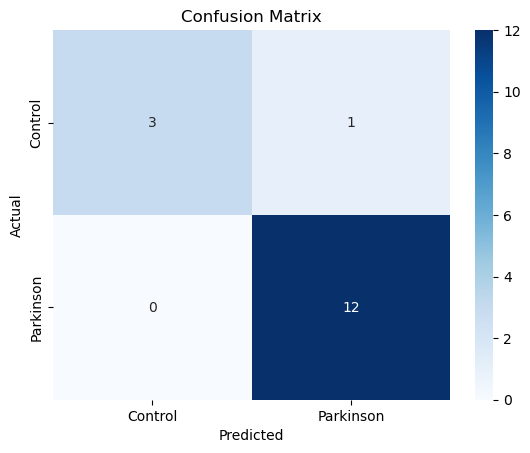

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "Parkinson"], yticklabels=["Control", "Parkinson"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

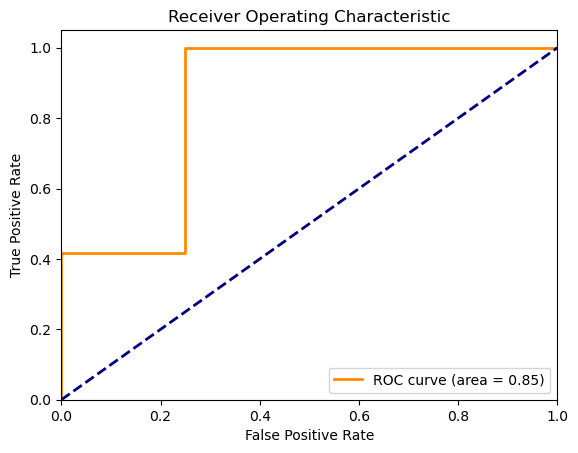

In [29]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Save the trained model
with open("parkinson_prediction_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

In [31]:
# Save the scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [32]:
# Function to predict Parkinson's disease from a new file
def get_feature(file_path, parkinson_target):
    df = pd.read_csv(file_path, sep=';', header=None, names=header_row)
    
    df_static = df[df["Test_ID"] == 0]
    df_dynamic = df[df["Test_ID"] == 1]
    df_stcp = df[df["Test_ID"] == 2]
    
    initial_timestamp = df['Timestamp'].values[0] if df.shape[0] else 0
    df['Timestamp'] = df['Timestamp'] - initial_timestamp

    data_point = [
        get_no_strokes(df_static), get_no_strokes(df_dynamic),
        get_speed(df_static), get_speed(df_dynamic),
        find_velocity(df_static)[5], find_velocity(df_static)[6], find_velocity(df_static)[7],
        find_velocity(df_dynamic)[5], find_velocity(df_dynamic)[6], find_velocity(df_dynamic)[7],
        find_acceleration(df_static)[5], find_acceleration(df_static)[6], find_acceleration(df_static)[7],
        find_acceleration(df_dynamic)[5], find_acceleration(df_dynamic)[6], find_acceleration(df_dynamic)[7],
        find_jerk(df_static)[5], find_jerk(df_static)[6], find_jerk(df_static)[7],
        find_jerk(df_dynamic)[5], find_jerk(df_dynamic)[6], find_jerk(df_dynamic)[7],
        NCV_per_halfcircle(df_static)[1], NCV_per_halfcircle(df_dynamic)[1],
        NCA_per_halfcircle(df_static)[1], NCA_per_halfcircle(df_dynamic)[1],
        get_in_air_time(df_stcp), get_on_surface_time(df_static), get_on_surface_time(df_dynamic),
        parkinson_target
    ]
    
    return data_point




data_points = []


for file in control_file_list:
    data_points.append(get_feature(file, 0))

for file in parkinson_file_list:
    data_points.append(get_feature(file, 1))

def predict_parkinson(file_path):
    try:
        features = get_feature(file_path, None)[:-1]  # Exclude the target
        features_df = pd.DataFrame([features], columns=feature_names[:-1])  # Convert to DataFrame with feature names
        features_scaled = scaler.transform(features_df)
        prediction = model.predict(features_scaled)
        return prediction[0]
    except Exception as e:
        print(f"Error predicting Parkinson's: {e}")
        return None

def open_file():
    try:
        file_path = filedialog.askopenfilename()
        if file_path:
            result = predict_parkinson(file_path)
            if result is not None:
                result_label.config(text="Parkinson" if result == 1 else "Control")
            else:
                result_label.config(text="Error predicting")
    except Exception as e:
        print(f"Error opening file: {e}")

root = tk.Tk()
root.title("Parkinson's Prediction")
root.geometry("400x200")

open_file_button = tk.Button(root, text="Open File", command=open_file)
open_file_button.pack(pady=20)

result_label = tk.Label(root, text="")
result_label.pack(pady=20)

root.mainloop()